In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm

In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [4]:
mtype = "mlr_hier_cov_slow"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [5]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symm=True, perm=True)
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=2, mean_size=2500.0
level=2, num_groups=4, mean_size=1250.0
level=3, num_groups=8, mean_size=625.0
level=4, num_groups=16, mean_size=312.5
level=5, num_groups=5000, mean_size=1.0


In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.951425429157005, noise_var=7.150831628949083
SNR=4.048679500710302, signal_to_noise=4


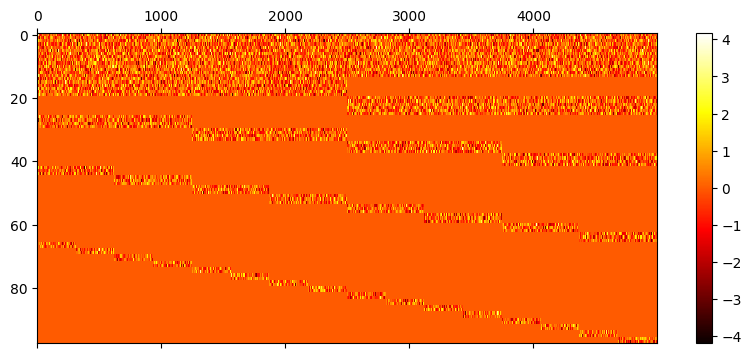

(5000, 98)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [9]:
C.shape, Z.shape, unpermuted_A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [10]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [11]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)
permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

num_levels=6, num_sparsities=16
(16, 5) [ 0  1  3  7 15]


# True model loglikelihoods

In [12]:
true_F, true_D = true_mlr.B[:, :-1]+0, true_D_noise+0
true_mfm = mfm.MFModel(F=true_F, D=true_D, hpart=F_hpart, ranks=ranks)
true_mfm.inv_coefficients(det=True)

true_train_obj = mfm.fast_loglikelihood_value(true_mfm, Y[:, true_mfm.pi_inv])
exp_true_obj = mfm.fast_exp_true_loglikelihood_value(true_mfm)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_obj}")

TR: train ll=-11534.532547471656, exp ll=-11536.310816584419


/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        true_mfm, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)

-11536.310816584424

# Frobenius norm-based loss

In [14]:
frob_mfm, losses = mfm.fast_frob_fit_loglikehood(unpermuted_A, Y, F_hpart, hpart, ranks, printing=True, eps_ff=1e-3)
frob_mfm.inv_coefficients(det=True)
obj_frob = mfm.fast_loglikelihood_value(frob_mfm, Y[:, frob_mfm.pi_inv])
obj_frob_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        frob_mfm, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)
print(f"FR: train ll={obj_frob}, test ll={obj_frob_exp}")
obj_frobs = {str(ranks):{"exp":obj_frob_exp, "train":obj_frob}}

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.2634191004275577, [14  6  4  3  2  1]
itr=1, 0.2634191004275577, [14  6  4  3  2  1]
itr=1, 0.22817724088024635, [14  6  4  3  2  1], time_v_epoch=6.417646884918213, time_loss=0.38227319717407227
itr=2, 0.22038419853322264, [14  6  4  3  2  1], time_v_epoch=7.594715118408203, time_loss=0.4414641857147217
itr=3, 0.2171040805027495, [14  6  4  3  2  1], time_v_epoch=7.423673868179321, time_loss=0.37273120880126953
itr=4, 0.21574939292963732, [14  6  4  3  2  1], time_v_epoch=7.597723007202148, time_loss=0.398547887802124
itr=5, 0.21519267654271246, [14  6  4  3  2  1], time_v_epoch=6.762702941894531, time_loss=0.4249107837677002
itr=6, 0.21496258463511614, [14  6  4  3  2  1], time_v_epoch=6.816581726074219, time_loss=0.3737349510192871
itr=7, 0.21486652413392218, [14  6  4  3  2  1], time_v_epoch=7.171852111816406, time_loss=0.501488208770752
FR: train ll=-11293.696163256205, test ll=-11884.339741107699


/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [15]:
print(f"FR: train ll={obj_frob}, exp ll={obj_frob_exp}")

FR: train ll=-11293.696163256205, exp ll=-11884.339741107699


# MLE-based loss

In [16]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, F_hpart, printing=True, max_iter=400, freq=100)

t=0, obj=-15828.549018834581
t=100, obj=-11313.220825380406
t=200, obj=-11292.031842063634
t=300, obj=-11284.116768457963
t=399, obj=-11279.90454353832


In [17]:
ll_hier = np.copy(np.array(loglikelihoods))

In [18]:
obj_exp = mfm.fast_exp_loglikelihood_value(np.concatenate([true_F, np.sqrt(true_D).reshape(-1, 1)], axis=1), 
                                                        fitted_mfm, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={obj_exp}")
ll_hier = {"train":ll_hier, "exp":obj_exp}

ML: train ll=-11279.90454353832, exp ll=-11869.949551264926


In [19]:
obj_frobs.values()

dict_values([{'exp': -11884.339741107699, 'train': -11293.696163256205}])

In [20]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# true model maximizes the likelihood of test data
assert exp_true_obj > obj_frobs[str(ranks)]["exp"] and exp_true_obj > ll_hier["exp"]
print(exp_true_obj, ll_hier["exp"], obj_frobs[str(ranks)]["exp"])

-11536.310816584419 -11869.949551264926 -11884.339741107699


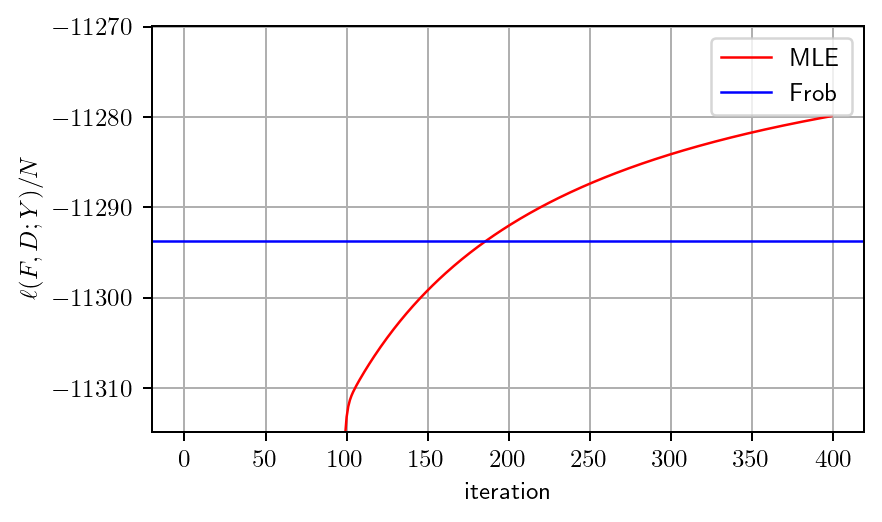

In [22]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 35, ll.max() + 10])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')